# Importing Libraries and Loading Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
coding = "ISO-8859-1"

 # Datatypes, Columns and Rows

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data Cleaning

<Axes: >

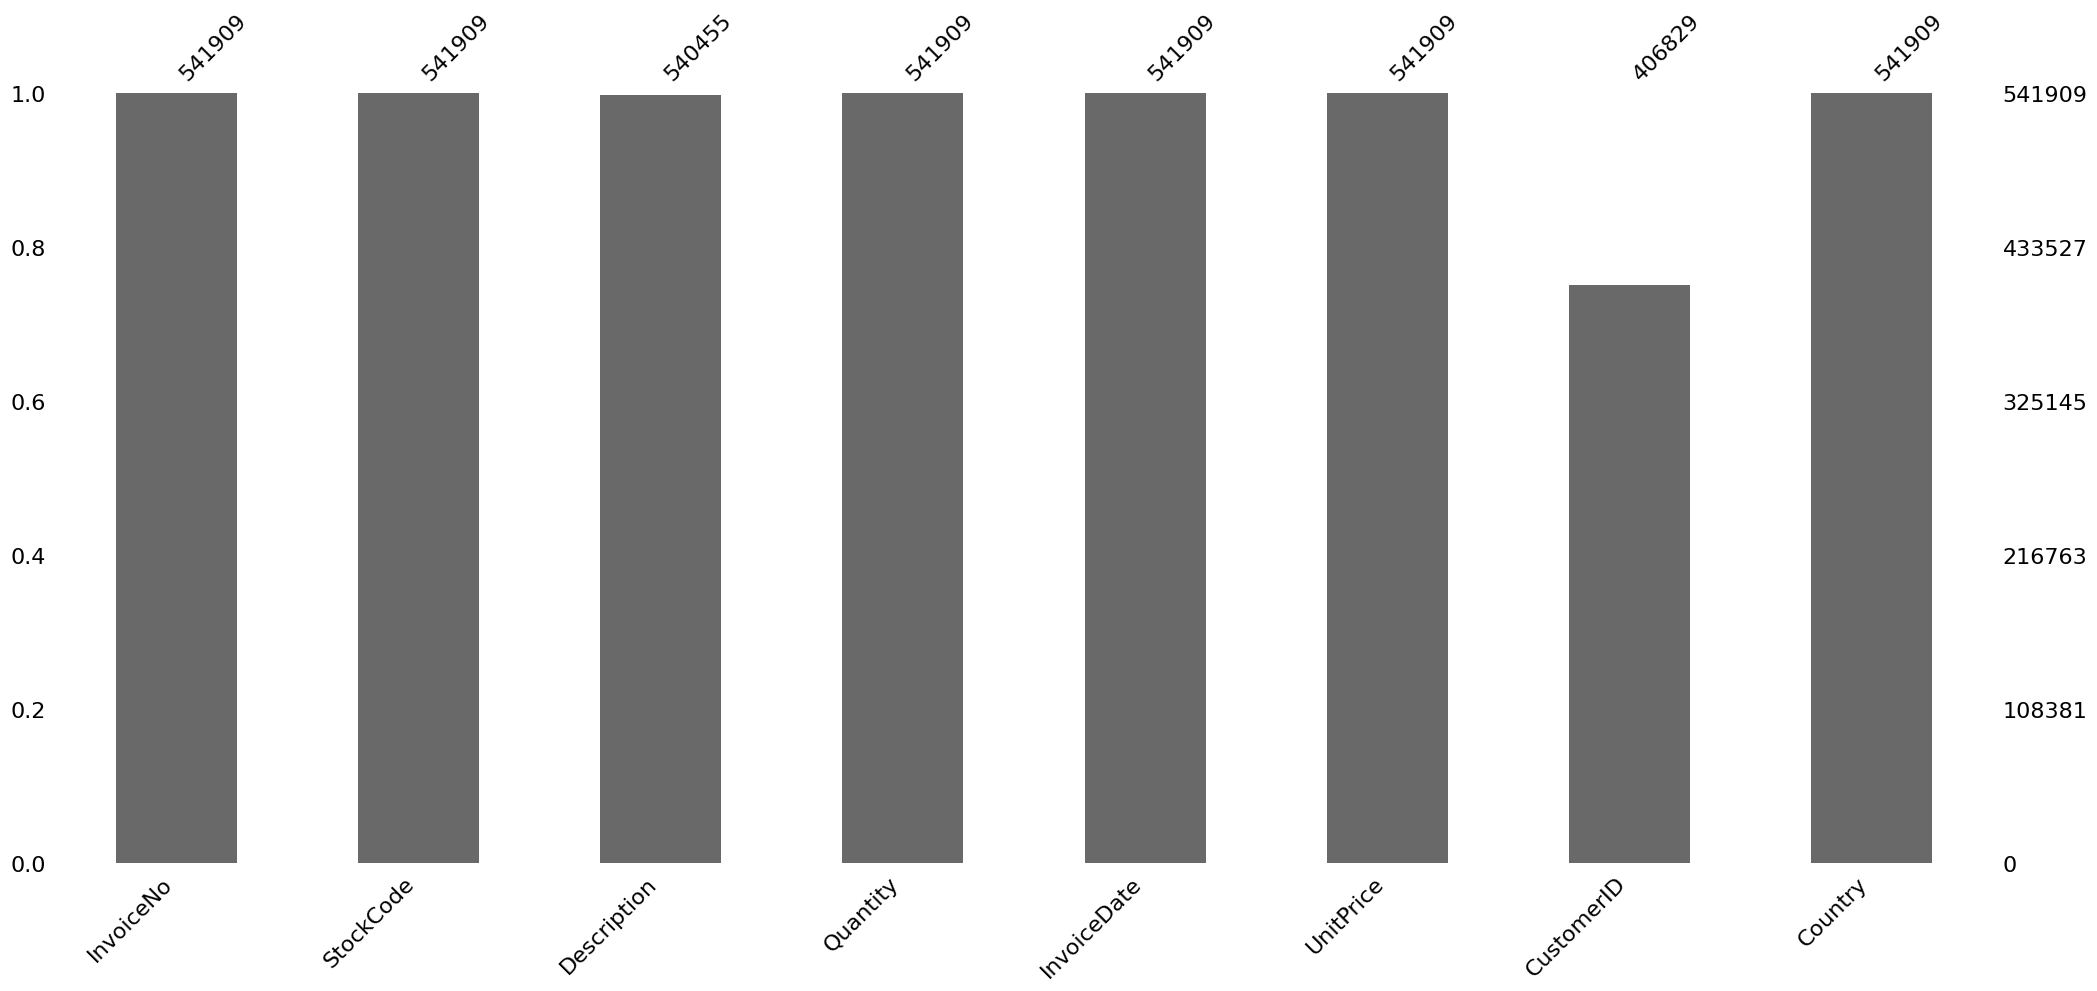

In [5]:
# Xoá dữ liệu thiếu
msno.bar(df)

In [6]:
df[df['CustomerID'].isnull()].count()

InvoiceNo      135080
StockCode      135080
Description    133626
Quantity       135080
InvoiceDate    135080
UnitPrice      135080
CustomerID          0
Country        135080
dtype: int64

<Axes: >

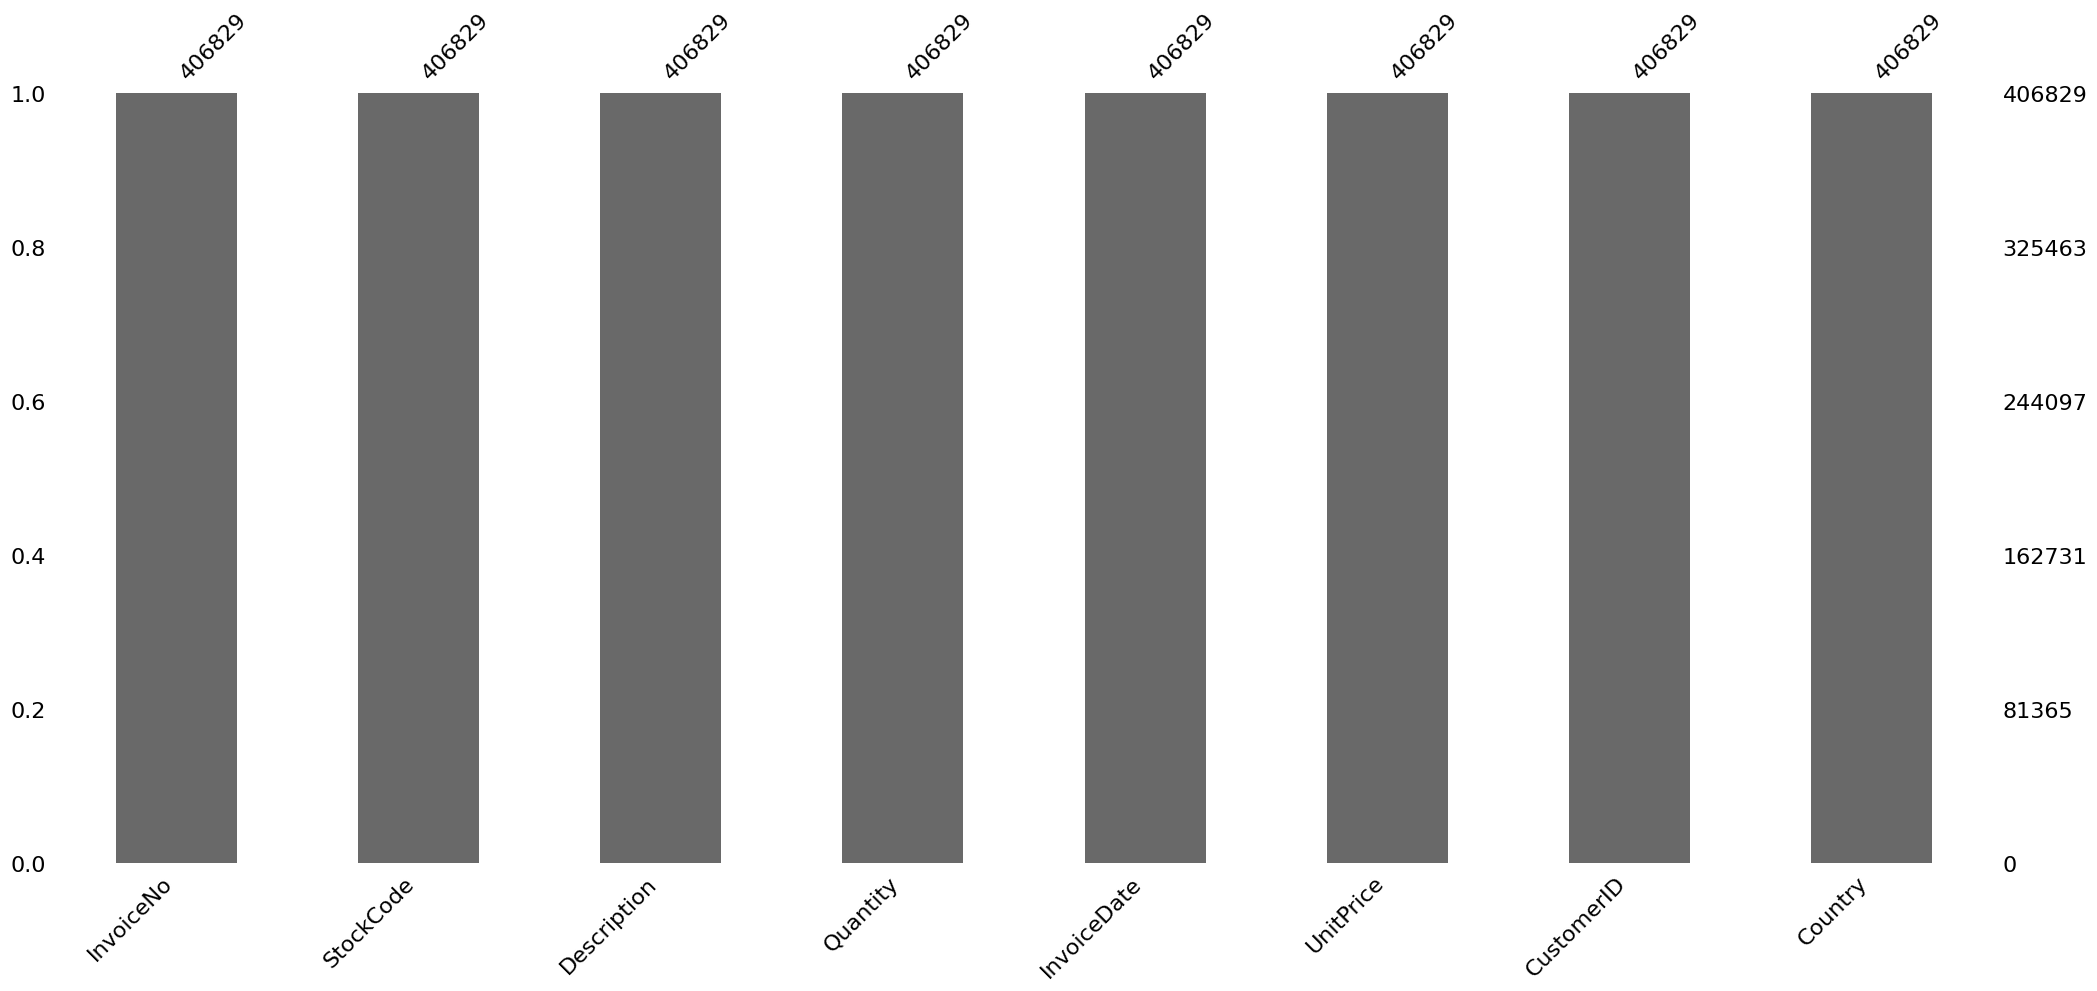

In [7]:
df.dropna(inplace=True)
msno.bar(df)

In [8]:
# thay đổi kiểu dữ liệu InvoiceDate sang datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [9]:
# Tính tổng tiền mỗi khách hàng đã chi tiêu
df['Total Amount Spent']= df['Quantity'] * df['UnitPrice']

total_amount = df['Total Amount Spent'].groupby(df['CustomerID']).sum()
total_amount = pd.DataFrame(total_amount).reset_index()
total_amount.head()

,CustomerID,Total Amount Spent
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
# Tính số giao dịch mỗi khách hàng đã thực hiện
transactions = df['InvoiceNo'].groupby(df['CustomerID']).count()
transaction = pd.DataFrame(transactions).reset_index()
transaction.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
# Tính thời gian kể từ giao dịch cuối cùng của mỗi khách hàng đến ngày cuối cùng trong dữ liệu
final = df['InvoiceDate'].max()
df['Last_transact'] = final - df['InvoiceDate']
LT = df.groupby(df['CustomerID']).min()['Last_transact']
LT = pd.DataFrame(LT).reset_index()
LT.head()

,CustomerID,Last_transact
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [12]:
# Kết hợp các DataFrame lại với nhau
df_new = pd.merge(total_amount, transaction, how='inner', on='CustomerID')
df_new = pd.merge(df_new, LT, how='inner', on='CustomerID')
df_new['Last_transact'] = df_new['Last_transact'].dt.days
df_new.head()

,CustomerID,Total Amount Spent,InvoiceNo,Last_transact
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


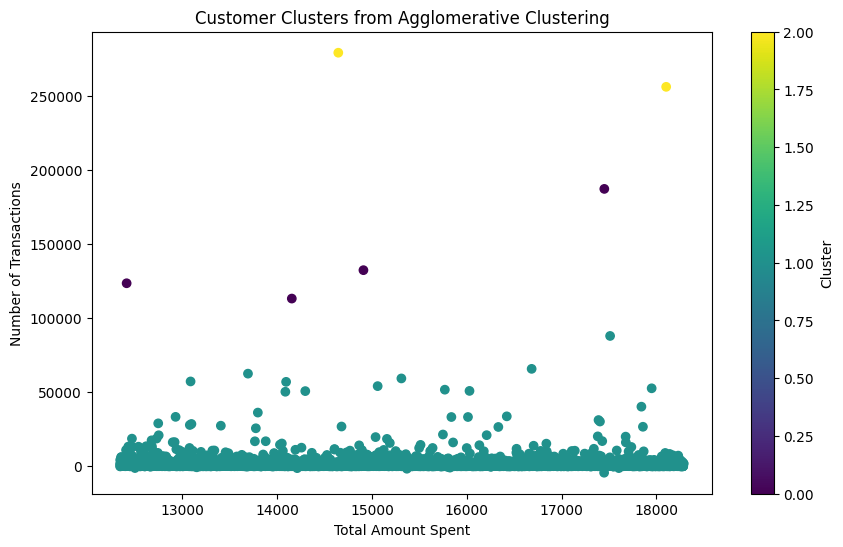

In [13]:
ac = AgglomerativeClustering(3, linkage='average')
ac_clusters = ac.fit_predict(df_new)
# Hiển thị các cụm sau khi phân cấp theo cách tiếp cận của scikit-learn
plt.figure(figsize=(10, 6))
plt.scatter(df_new.values[:,0], df_new.values[:,1], c=ac_clusters, cmap='viridis')
plt.title("Customer Clusters from Agglomerative Clustering")
plt.xlabel("Total Amount Spent")
plt.ylabel("Number of Transactions")
plt.colorbar(label="Cluster")
plt.show()

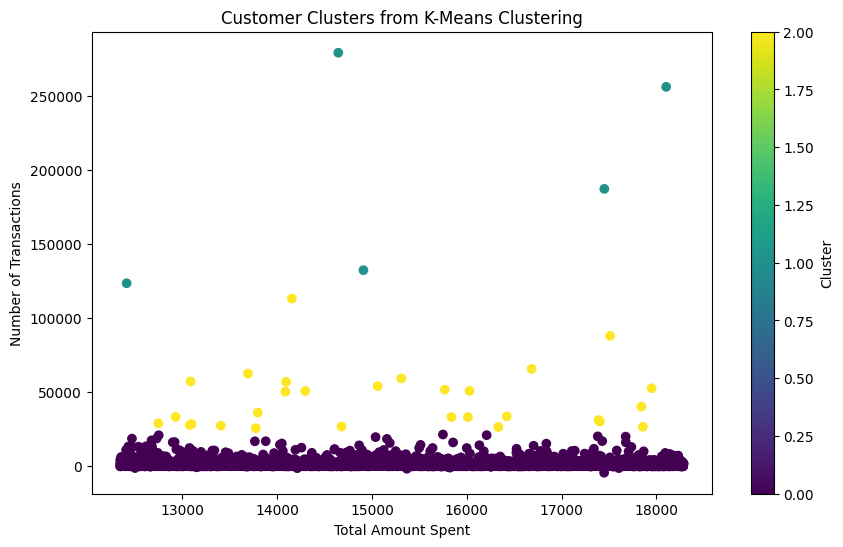

In [14]:
km = KMeans(3)
km_clusters = km.fit_predict(df_new)
# Hiển thị kết quả sau khi phân cụm K-mean
plt.figure(figsize=(10, 6))
plt.scatter(df_new.values[:,0], df_new.values[:,1], c=km_clusters, cmap='viridis')
plt.title("Customer Clusters from K-Means Clustering")
plt.xlabel("Total Amount Spent")
plt.ylabel("Number of Transactions")
plt.colorbar(label="Cluster")
plt.show()

In [15]:
# So sánh kết quả phân cụm của 2 mô hình với phương pháp tính Silhouette
print("Silhouette Scores for Wine Dataset:\n")
print("K-Means Clustering: ", silhouette_score(df_new, km_clusters))
print("Agg Clustering: ", silhouette_score(df_new, ac_clusters))

Silhouette Scores for Wine Dataset:

K-Means Clustering:  0.9244613935117746
K-Means Clustering:  0.9244613935117746
Agg Clustering:  0.9727752885265378
Agg Clustering:  0.9727752885265378
